In [3]:
from PIL import Image, ImageDraw, ImageFont
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from astropy.table import Table

# ignore warnings for readability
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import torch.nn as nn

import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)



Device: cpu


In [186]:
import os
import pandas as pd
from astropy.table import Table

# Load the main catalog
cat_dir = "/Users/marchuertascompany/Documents/data/COSMOS-Web/cats"
cat_name = "COSMOSWeb_master_v2.0.1-sersic-cgs_LePhare-v2_FlaggedM.fits"
cat_cosmos = Table.read(os.path.join(cat_dir, cat_name), format='fits')
names = [name for name in cat_cosmos.colnames if len(cat_cosmos[name].shape) <= 1]
cat = cat_cosmos[names].to_pandas()

# Define a function to load and merge a prediction catalog
def merge_with_predictions(cat, pred_path, filter_name):
    pred = pd.read_csv(pred_path)
    pred = pred.add_suffix(f'_{filter_name}')
    pred.rename(columns={f'id_str_{filter_name}': 'id_str'}, inplace=True)
    merged = cat.merge(pred, how='inner', right_on=f'id_str', left_on='Id', suffixes=(None, f'_{filter_name}'))
    return merged

# Paths to the prediction catalogs - CHANGE PATHS WHEN DOWNLOADED
pred_paths = {
    'f150w': "/Users/marchuertascompany/Documents/data/COSMOS-Web/zoobot/bars_COSMOS_f277w_m27_effnet.csv",
    'f277w': "/Users/marchuertascompany/Documents/data/COSMOS-Web/zoobot/bars_COSMOS_f277w_m27_effnet.csv",
    'f444w': "/Users/marchuertascompany/Documents/data/COSMOS-Web/zoobot/bars_COSMOS_f444w_m27_effnet.csv"
}

# Merge with each prediction catalog
merged_cat = cat.copy()
for filter_name, pred_path in pred_paths.items():
    merged_cat = merge_with_predictions(merged_cat, pred_path, filter_name)

# Remove redundant 'id_str' columns after merging
for filter_name in pred_paths.keys():
    col_name = f'id_str_{filter_name}'
    if col_name in merged_cat.columns:
        merged_cat.drop(columns=[col_name], inplace=True)

# Final merged catalog
merge = merged_cat

# Display the merged catalog
print(merge.head())


   Id    RA_DETEC  DEC_DETEC    RA_MODEL  DEC_MODEL        X_TILE      Y_TILE  \
0   2  149.863180   2.497745  149.863391   2.497355  17710.748047   17.120798   
1   8  149.866700   2.497064  149.866714   2.497059  17286.269531   84.545654   
2  10  149.938853   2.472919  149.938848   2.472913   8166.365723  318.987549   
3  11  149.929907   2.474917  149.929863   2.474854   9256.284180  177.657639   
4  12  149.930622   2.475213  149.930619   2.475138   9187.951172  240.293930   

     AREA    RADIUS    RADIUS_err  ...  \
0  9672.0  0.000262  5.857034e-06  ...   
1   112.0  0.000060  1.088756e-06  ...   
2   102.0  0.000042  2.236739e-06  ...   
3   207.0  0.000101  3.648799e-07  ...   
4   735.0  0.000185  1.507509e-06  ...   

   t8_not_edge_on_bulge__small_pred_f444w  \
0                               14.640614   
1                               20.994883   
2                               21.213083   
3                                9.287796   
4                               29.

In [187]:
print(len(merge))

411787


In [161]:
print(cat.morph_flag_f150w)

0         2
1         0
2         2
3         2
4         2
         ..
178375    2
178376    2
178377    2
178378    2
178379    2
Name: morph_flag_f150w, Length: 178380, dtype: int64


In [254]:
# Calculate p_feature and p_bar for each filter
def calculate_probabilities(df, filter_suffix):
    count_feature = df[f't0_smooth_or_featured__features_or_disk_pred_{filter_suffix}'].values
    count_smooth = df[f't0_smooth_or_featured__smooth_pred_{filter_suffix}'].values
    count_artifact = df[f't0_smooth_or_featured__star_artifact_or_bad_zoom_pred_{filter_suffix}'].values
    p_feature = count_feature / (count_feature + count_smooth + count_artifact)

    count_strong = df[f't4_is_there_a_bar__strong_bar_pred_{filter_suffix}'].values
    count_weak = df[f't4_is_there_a_bar__weak_bar_pred_{filter_suffix}'].values
    count_none = df[f't4_is_there_a_bar__no_bar_pred_{filter_suffix}'].values
    p_strong = count_strong / (count_strong + count_weak + count_none)
    p_weak = count_weak / (count_strong + count_weak + count_none)
    p_bar = p_strong + p_weak

    return p_feature, p_bar

# Calculate probabilities for each filter
p_feature_f150w, p_bar_f150w = calculate_probabilities(merge, 'f150w')
p_feature_f277w, p_bar_f277w = calculate_probabilities(merge, 'f277w')
p_feature_f444w, p_bar_f444w = calculate_probabilities(merge, 'f444w')

# Create conditions for redshift ranges
conditions = [
    (merge['LP_zfinal'] < 1),
    (merge['LP_zfinal'] >= 1) & (merge['LP_zfinal'] < 3),
    (merge['LP_zfinal'] >= 3)
]

# Use np.select to apply the conditions and choose the corresponding values
import numpy as np

merge['p_feature'] = np.select(conditions, [p_feature_f150w, p_feature_f277w, p_feature_f444w], default=np.nan)
merge['p_bar'] = np.select(conditions, [p_bar_f150w, p_bar_f277w, p_bar_f444w], default=np.nan)
merge['RF_mag'] = np.select(conditions, [merge.MAG_MODEL_F150W.values, merge.MAG_MODEL_F277W.values-0.6, merge.MAG_MODEL_F444W.values-0.5], default=np.nan)

# Display the updated DataFrame
print(merge[['LP_zfinal', 'p_feature', 'p_bar','RF_mag']].head())


   LP_zfinal  p_feature     p_bar     RF_mag
0     1.7603   0.207545  0.192138  18.163360
1     1.2705   0.260875  0.171983  25.394156
2     0.5977   0.184601  0.150594  26.472796
3     0.9186   0.217786  0.222477  21.984324
4     1.9673   0.705785  0.263875  22.878903


(array([  495.,   758.,  1217.,  1628.,  2058.,  2809.,  3399.,  3893.,
         4777.,  5913.,  7187.,  9036., 10932., 12673., 15401., 18235.,
        21445., 24630., 28348., 31766., 31958., 30656., 27685., 22594.,
        17771., 13859., 10542.,  8232.,  6317.,  5129.,  4120.,  3173.,
         2650.,  2181.,  1864.,  1532.,  1264.,  1122.,  1021.]),
 array([-2.00000000e+00, -1.90000000e+00, -1.80000000e+00, -1.70000000e+00,
        -1.60000000e+00, -1.50000000e+00, -1.40000000e+00, -1.30000000e+00,
        -1.20000000e+00, -1.10000000e+00, -1.00000000e+00, -9.00000000e-01,
        -8.00000000e-01, -7.00000000e-01, -6.00000000e-01, -5.00000000e-01,
        -4.00000000e-01, -3.00000000e-01, -2.00000000e-01, -1.00000000e-01,
         1.77635684e-15,  1.00000000e-01,  2.00000000e-01,  3.00000000e-01,
         4.00000000e-01,  5.00000000e-01,  6.00000000e-01,  7.00000000e-01,
         8.00000000e-01,  9.00000000e-01,  1.00000000e+00,  1.10000000e+00,
         1.20000000e+00,  1.30000000e+

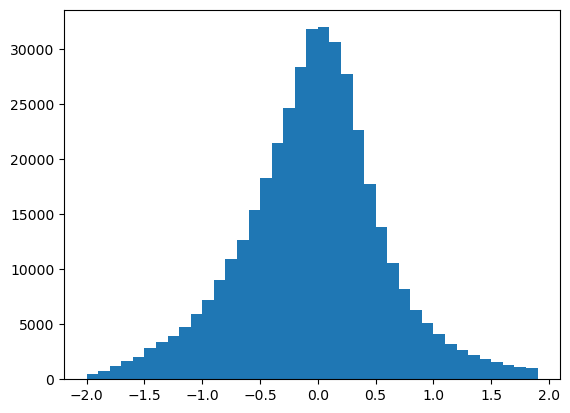

In [195]:
plt.hist(merge.MAG_MODEL_F150W.values-merge.MAG_MODEL_F444W.values,bins=np.arange(-2,2,0.1))

In [165]:
print(len(merge))

113056


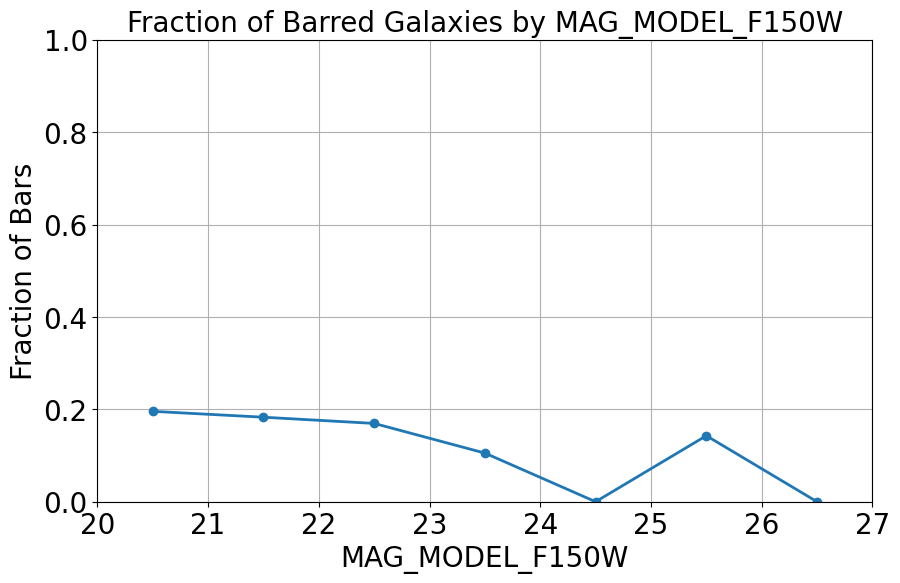

In [255]:
#select bars

bars_lz = merge.query('LP_zfinal<1.5 and LP_mass_med_PDF>10 and AXRATIO>0.5 and p_bar>0.5 and p_feature>0.5')
disks_lz = merge.query('LP_zfinal<1.5 and LP_mass_med_PDF>10  and AXRATIO>0.5 and p_feature>0.5')

m150_disks = disks_lz.RF_mag.values
m150_bars = bars_lz.RF_mag.values


bars_hz = merge.query('LP_zfinal>2 and LP_zfinal<3 and LP_mass_med_PDF>10 and LP_mass_med_PDF<11 and AXRATIO>0.5 and p_bar>0.5 and p_feature>0.5')
disks_hz = merge.query('LP_zfinal>2 and LP_zfinal<3 and LP_mass_med_PDF>10 and AXRATIO>0.5 and p_feature>0.5')

m150_disks = disks_lz.RF_mag.values
m150_bars = bars_lz.RF_mag.values


bins = np.arange(20, 28, 1)

# Histogram the data into these bins
hist_disks, _ = np.histogram(m150_disks, bins=bins)
hist_bars, _ = np.histogram(m150_bars, bins=bins)

# Calculate the fraction of bars
total = hist_disks + hist_bars
fraction_bars = np.divide(hist_bars, total, where=total!=0)  # Avoid division by zero

# Bin centers for plotting
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(bin_centers, fraction_bars, marker='o', linestyle='-', linewidth=2)
plt.xlabel('MAG_MODEL_F150W', fontsize=20)
plt.ylabel('Fraction of Bars', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim([20, 27])
plt.ylim([0, 1])  # Fraction ranges from 0 to 1
plt.grid(True)
plt.title('Fraction of Barred Galaxies by MAG_MODEL_F150W', fontsize=20)
plt.show()


[708 619 109  34  16   6   1]
[170 131  26   4   0   1   0]
[0.19362187 0.17466667 0.19259259 0.10526316 0.         0.14285714
 0.        ]
[ 12  66 148  20   1   0   0]
[ 0  7 24  2  0  0  0]
[0.         0.09589041 0.13953488 0.09090909 0.         0.
 0.        ]


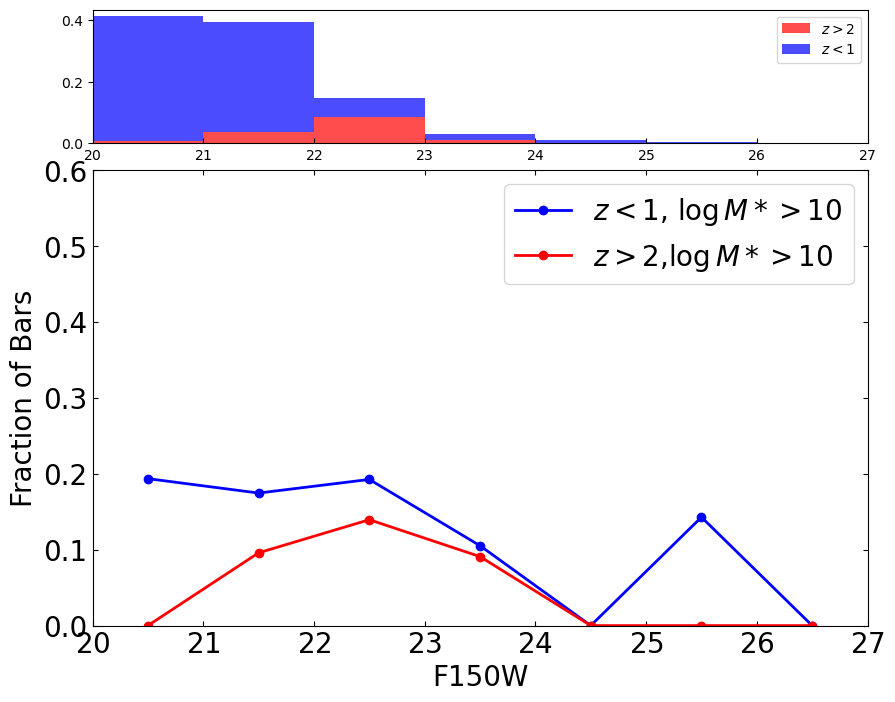

In [238]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import ScalarFormatter

def calculate_fractions_and_plot(m150_disks, m150_bars, ax, label,color):
    # Histogram the data into these bins
    hist_disks, _ = np.histogram(m150_disks, bins=bins)
    hist_bars, _ = np.histogram(m150_bars, bins=bins)

    print(hist_disks)
    print(hist_bars)
    
    # Calculate the fraction of bars
    total = hist_disks + hist_bars
    #print(total[total>0])
    fraction_bars = np.divide(hist_bars, total)  # Avoid division by zero
    fraction_bars[total==0]=0
    print(fraction_bars)

    # Plot
    ax.plot(bin_centers, fraction_bars, marker='o', linestyle='-', linewidth=2, label=label,c=color)

# Create figure and specify grid layout
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(4, 4, figure=fig)

# Main plot for fractions
ax_main = fig.add_subplot(gs[1:4, :])
ax_histx = fig.add_subplot(gs[0, :], sharex=ax_main)

# Plot low-z data
calculate_fractions_and_plot(disks_lz.RF_mag.values, bars_lz.RF_mag.values, ax_main, '$z<1$, $\log M*>10$',color='blue')

# Plot high-z data
calculate_fractions_and_plot(disks_hz.RF_mag.values, bars_hz.RF_mag.values, ax_main, '$z>2$,$\log M*>10$',color='red')

# Set labels and limits
ax_main.set_xlabel('F150W', fontsize=20)
ax_main.set_ylabel('Fraction of Bars', fontsize=20)
ax_main.set_xlim([20, 27])
ax_main.set_ylim([0, .6])
ax_main.legend(fontsize=20)
ax_main.tick_params(axis='both', which='both', direction='in', top=True, right=True,labelsize=20)
ax_histx.tick_params(axis='x', which='both', direction='in')

# Enable scientific notation
#ax_main.ticklabel_format( xis='y', scilimits=(0,0))
ax_main.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax_histx.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))

# Plot filled histograms on top
ax_histx.hist([disks_hz.RF_mag.values,disks_lz.RF_mag.values], bins=bins, label=['$z>2$','$z<1$'], color=['red','blue'],alpha=0.7, stacked=True,density=True)
#ax_histx.hist([disks_lz.MAG_MODEL_F150W.values], bins=bins, label=['$z<1$'], color=['blue'],alpha=0.7, stacked=True,density=True)
# Adding legend to histograms
ax_histx.legend(loc='upper right')

plt.show()


[  4 424 805 473 203  95  47]
[  0  94 180 134  63  22  11]
[0.         0.18146718 0.18274112 0.22075783 0.23684211 0.18803419
 0.18965517]
[  1  92 111  31   3   4   2]
[ 0 11 16  4  1  0  1]
[0.         0.10679612 0.12598425 0.11428571 0.25       0.
 0.33333333]


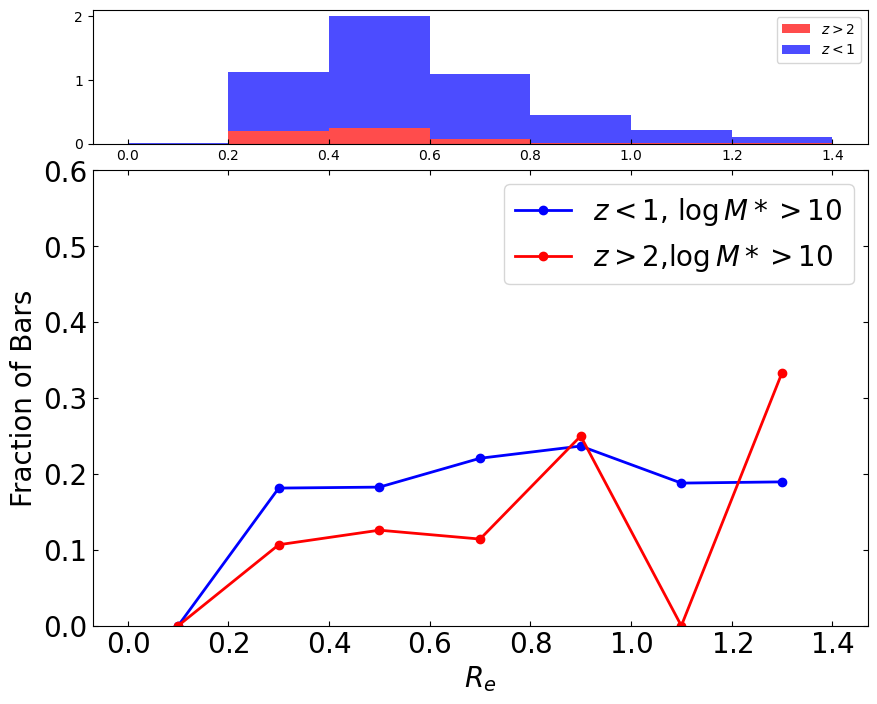

In [239]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import ScalarFormatter

def calculate_fractions_and_plot(m150_disks, m150_bars, ax, label,color,bins = np.arange(0, 1.5,0.2)):
    # Histogram the data into these bins
    hist_disks, _ = np.histogram(m150_disks, bins=bins)
    hist_bars, _ = np.histogram(m150_bars, bins=bins)

    print(hist_disks)
    print(hist_bars)
    
    # Calculate the fraction of bars
    total = hist_disks + hist_bars
    #print(total[total>0])
    fraction_bars = np.divide(hist_bars, total)  # Avoid division by zero
    fraction_bars[total==0]=0
    print(fraction_bars)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    # Plot
    ax.plot(bin_centers, fraction_bars, marker='o', linestyle='-', linewidth=2, label=label,c=color)

# Create figure and specify grid layout
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(4, 4, figure=fig)

# Main plot for fractions
ax_main = fig.add_subplot(gs[1:4, :])
ax_histx = fig.add_subplot(gs[0, :], sharex=ax_main)

# Plot low-z data
calculate_fractions_and_plot(disks_lz.RADIUS.values*3600, bars_lz.RADIUS.values*3600, ax_main, '$z<1$, $\log M*>10$',color='blue')

# Plot high-z data
calculate_fractions_and_plot(disks_hz.RADIUS.values*3600, bars_hz.RADIUS.values*3600, ax_main, '$z>2$,$\log M*>10$',color='red')

# Set labels and limits
ax_main.set_xlabel('$R_e$', fontsize=20)
ax_main.set_ylabel('Fraction of Bars', fontsize=20)
#ax_main.set_xlim([20, 27])
ax_main.set_ylim([0, .6])
ax_main.legend(fontsize=20)
ax_main.tick_params(axis='both', which='both', direction='in', top=True, right=True,labelsize=20)
ax_histx.tick_params(axis='x', which='both', direction='in')

# Enable scientific notation
#ax_main.ticklabel_format( xis='y', scilimits=(0,0))
ax_main.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax_histx.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))

# Plot filled histograms on top
ax_histx.hist([disks_hz.RADIUS.values*3600,disks_lz.RADIUS.values*3600], bins=np.arange(0, 1.5,0.2), label=['$z>2$','$z<1$'], color=['red','blue'],alpha=0.7, stacked=True,density=True)
#ax_histx.hist([disks_lz.RADIUS.values], bins=bins, label=['$z<1$'], color=['blue'],alpha=0.7, stacked=True,density=True)
# Adding legend to histograms
ax_histx.legend(loc='upper right')

plt.show()


[ 259  763 1013  424  123   31   11    8]
[  0  25  94 197  62  28   8   0]


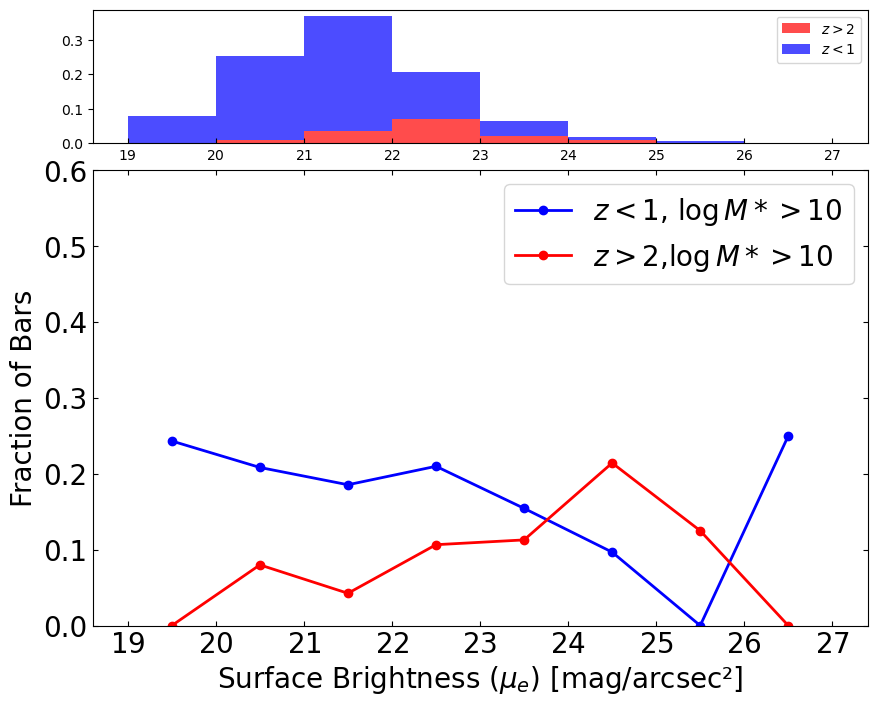

In [210]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import ScalarFormatter

def calculate_surface_brightness(magnitude, radius):
    """
    Calculate the mean surface brightness within the effective radius.

    Parameters:
    magnitude (float): Total magnitude of the galaxy.
    radius (float): Effective radius in arcseconds.

    Returns:
    float: Mean surface brightness within the effective radius (mag/arcsec²).
    """
    return magnitude + 2.5 * np.log10(2 * np.pi * radius**2)

def calculate_fractions_and_plot(mag_disks, radius_disks, mag_bars, radius_bars, ax, label, color, bins):
    # Calculate surface brightness
    mu_disks = calculate_surface_brightness(mag_disks, radius_disks)
    mu_bars = calculate_surface_brightness(mag_bars, radius_bars)
    
    # Histogram the data into these bins
    hist_disks, _ = np.histogram(mu_disks, bins=bins)
    hist_bars, _ = np.histogram(mu_bars, bins=bins)
    
    # Calculate the fraction of bars
    total = hist_disks + hist_bars
    print(total)
    fraction_bars = np.divide(hist_bars, total)  # Avoid division by zero
    fraction_bars[total == 0] = 0

    bin_centers = (bins[:-1] + bins[1:]) / 2
    # Plot
    ax.plot(bin_centers, fraction_bars, marker='o', linestyle='-', linewidth=2, label=label, color=color)

# Create figure and specify grid layout
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(4, 4, figure=fig)

# Main plot for fractions
ax_main = fig.add_subplot(gs[1:4, :])
ax_histx = fig.add_subplot(gs[0, :], sharex=ax_main)

# Define bins for surface brightness
mu_bins = np.arange(19, 28, 1)

# Plot low-z data
calculate_fractions_and_plot(
    disks_lz.RF_mag.values, disks_lz.RADIUS.values * 3600,
    bars_lz.RF_mag.values, bars_lz.RADIUS.values * 3600,
    ax_main, '$z<1$, $\log M*>10$', color='blue', bins=mu_bins
)

# Plot high-z data
calculate_fractions_and_plot(
    disks_hz.RF_mag.values, disks_hz.RADIUS.values * 3600,
    bars_hz.RF_mag.values, bars_hz.RADIUS.values * 3600,
    ax_main, '$z>2$,$\log M*>10$', color='red', bins=mu_bins
)

# Set labels and limits
ax_main.set_xlabel('Surface Brightness ($\mu_e$) [mag/arcsec²]', fontsize=20)
ax_main.set_ylabel('Fraction of Bars', fontsize=20)
ax_main.set_ylim([0, .6])
ax_main.legend(fontsize=20)
ax_main.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=20)
ax_histx.tick_params(axis='x', which='both', direction='in')

# Enable scientific notation
ax_main.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax_histx.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))

# Calculate surface brightness for histograms
mu_disks_lz = calculate_surface_brightness(disks_lz.RF_mag.values, disks_lz.RADIUS.values * 3600)
mu_disks_hz = calculate_surface_brightness(disks_hz.RF_mag.values, disks_hz.RADIUS.values * 3600)

# Plot filled histograms on top
ax_histx.hist([mu_disks_hz, mu_disks_lz], bins=mu_bins, label=['$z>2$', '$z<1$'], color=['red', 'blue'], alpha=0.7, stacked=True, density=True)

# Adding legend to histograms
ax_histx.legend(loc='upper right')

plt.show()


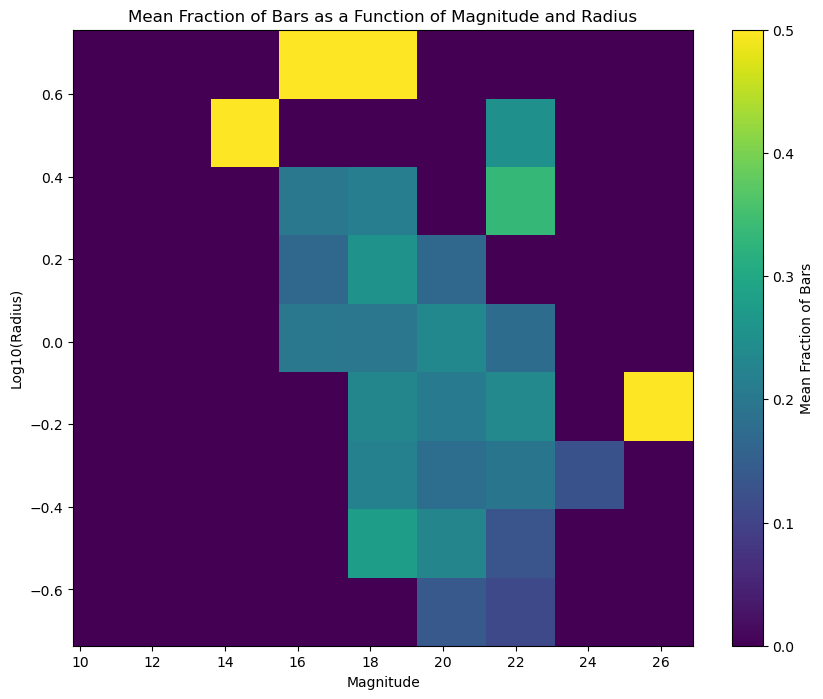

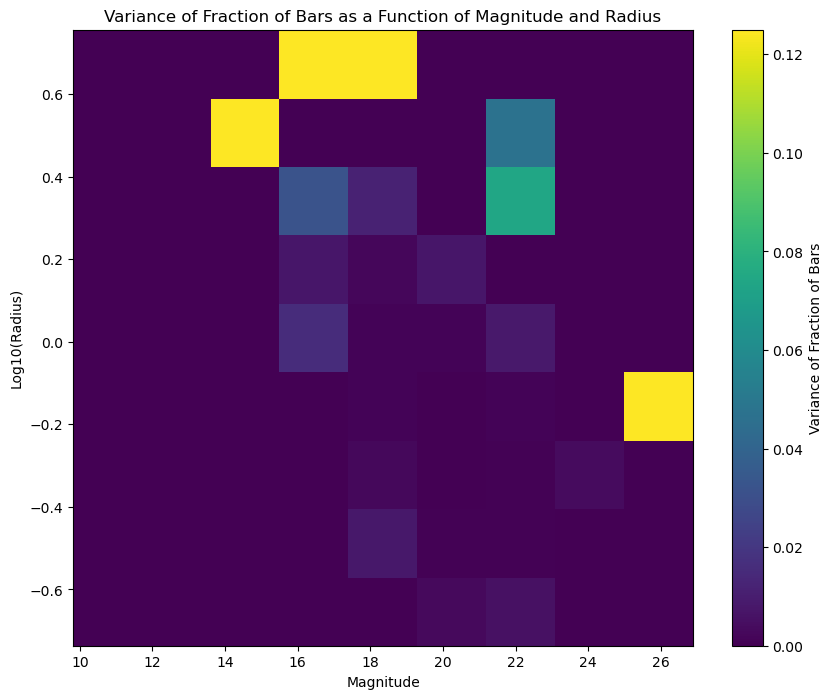

Estimated fraction of bars for magnitude 20.0 and radius 0.0004166666666666667 degrees: 0.2222222222222222


In [256]:
import numpy as np
import matplotlib.pyplot as plt

# Create the 2D histogram for bars
bars_mag = bars_lz.RF_mag.values
bars_radius = np.log10(bars_lz.RADIUS.values * 3600)
disks_mag = disks_lz.RF_mag.values
disks_radius = np.log10(disks_lz.RADIUS.values * 3600)

# Define bin edges
mag_bins = np.linspace(min(min(bars_mag), min(disks_mag)), max(max(bars_mag), max(disks_mag)), 10)
radius_bins = np.linspace(min(min(bars_radius), min(disks_radius)), max(max(bars_radius), max(disks_radius)), 10)

# Compute the 2D histograms
bars_hist, xedges, yedges = np.histogram2d(bars_mag, bars_radius, bins=[mag_bins, radius_bins])
disks_hist, _, _ = np.histogram2d(disks_mag, disks_radius, bins=[mag_bins, radius_bins])

# Calculate the total histogram
total_hist = bars_hist + disks_hist

# Calculate the mean fraction and the variance
mean_fraction_hist = np.zeros_like(bars_hist)
variance_hist = np.zeros_like(bars_hist)
nonzero_bins = total_hist > 0
mean_fraction_hist[nonzero_bins] = bars_hist[nonzero_bins] / total_hist[nonzero_bins]
variance_hist[nonzero_bins] = (mean_fraction_hist[nonzero_bins] * (1 - mean_fraction_hist[nonzero_bins])) / total_hist[nonzero_bins]

# Plot the mean fraction histogram
plt.figure(figsize=(10, 8))
plt.imshow(mean_fraction_hist.T, origin='lower', aspect='auto', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='viridis')
plt.colorbar(label='Mean Fraction of Bars')
plt.xlabel('Magnitude')
plt.ylabel('Log10(Radius)')
plt.title('Mean Fraction of Bars as a Function of Magnitude and Radius')
plt.show()

# Plot the variance histogram
plt.figure(figsize=(10, 8))
plt.imshow(variance_hist.T, origin='lower', aspect='auto', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='viridis')
plt.colorbar(label='Variance of Fraction of Bars')
plt.xlabel('Magnitude')
plt.ylabel('Log10(Radius)')
plt.title('Variance of Fraction of Bars as a Function of Magnitude and Radius')
plt.show()

def get_fraction_of_bars(mag, radius):
    """
    Given a magnitude and radius, return the estimated fraction of bars in that bin
    by sampling from a Poisson distribution.
    
    Parameters:
    mag (float): Magnitude value.
    radius (float): Radius value (not logarithmic).
    
    Returns:
    float: Estimated fraction of bars in the corresponding bin.
    """
    log_radius = np.log10(radius * 3600)
    
    # Find the bin indices for the given magnitude and radius
    mag_idx = np.digitize(mag, mag_bins) - 1
    radius_idx = np.digitize(log_radius, radius_bins) - 1
    
    # Ensure indices are within the valid range
    if mag_idx < 0 or mag_idx >= mean_fraction_hist.shape[0] or radius_idx < 0 or radius_idx >= mean_fraction_hist.shape[1]:
        return 0.0  # or np.nan or some other value to indicate out of range
    
    # Get the mean and variance for the fraction of bars in the bin
    mean_fraction = mean_fraction_hist[mag_idx, radius_idx]
    variance = variance_hist[mag_idx, radius_idx]
    
    # If the variance is zero, return the mean fraction
    if variance == 0:
        return mean_fraction
    
    # Sample the bar counts from a Poisson distribution
    total_count = total_hist[mag_idx, radius_idx]
    bars_count = np.random.poisson(lam=bars_hist[mag_idx, radius_idx])
    
    # Calculate the fraction of bars
    fraction_bars = bars_count / total_count if total_count > 0 else 0.0
    
    return fraction_bars

# Example usage:
mag_example = 20.0
radius_example = 1.5 / 3600  # converting arcseconds back to degrees for input
fraction = get_fraction_of_bars(mag_example, radius_example)
print(f"Estimated fraction of bars for magnitude {mag_example} and radius {radius_example} degrees: {fraction}")


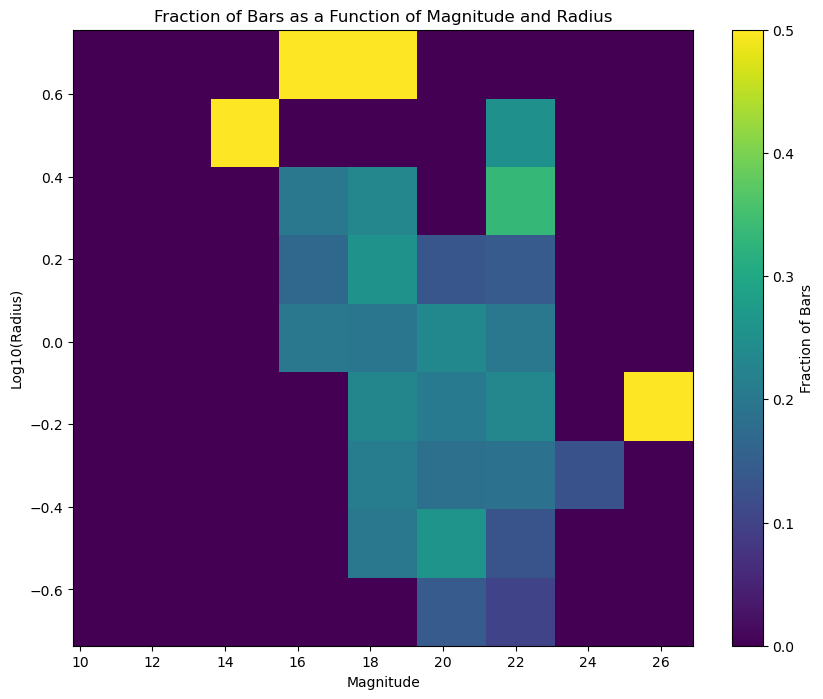

Fraction of bars for magnitude 20.0 and radius 0.0004166666666666667 degrees: 0.13333333333333333


In [211]:
import numpy as np
import matplotlib.pyplot as plt

# Create the 2D histogram for bars
bars_mag = bars_lz.RF_mag.values
bars_radius = np.log10(bars_lz.RADIUS.values * 3600)
disks_mag = disks_lz.RF_mag.values
disks_radius = np.log10(disks_lz.RADIUS.values * 3600)

# Define bin edges
mag_bins = np.linspace(min(min(bars_mag), min(disks_mag)), max(max(bars_mag), max(disks_mag)), 10)
radius_bins = np.linspace(min(min(bars_radius), min(disks_radius)), max(max(bars_radius), max(disks_radius)), 10)

# Compute the 2D histograms
bars_hist, xedges, yedges = np.histogram2d(bars_mag, bars_radius, bins=[mag_bins, radius_bins])
disks_hist, _, _ = np.histogram2d(disks_mag, disks_radius, bins=[mag_bins, radius_bins])

# Calculate the total histogram
total_hist = bars_hist + disks_hist

# Avoid division by zero
fraction_hist = np.zeros_like(bars_hist)
nonzero_bins = total_hist > 0
fraction_hist[nonzero_bins] = bars_hist[nonzero_bins] / total_hist[nonzero_bins]

# Plot the fraction histogram
plt.figure(figsize=(10, 8))
plt.imshow(fraction_hist.T, origin='lower', aspect='auto', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap='viridis')
plt.colorbar(label='Fraction of Bars')
plt.xlabel('Magnitude')
plt.ylabel('Log10(Radius)')
plt.title('Fraction of Bars as a Function of Magnitude and Radius')
plt.show()

def get_fraction_of_bars(mag, radius):
    """
    Given a magnitude and radius, return the fraction of bars in that bin.
    
    Parameters:
    mag (float): Magnitude value.
    radius (float): Radius value (not logarithmic).
    
    Returns:
    float: Fraction of bars in the corresponding bin.
    """
    log_radius = np.log10(radius * 3600)
    
    # Find the bin indices for the given magnitude and radius
    mag_idx = np.digitize(mag, mag_bins) - 1
    radius_idx = np.digitize(log_radius, radius_bins) - 1
    
    # Ensure indices are within the valid range
    if mag_idx < 0 or mag_idx >= fraction_hist.shape[0] or radius_idx < 0 or radius_idx >= fraction_hist.shape[1]:
        return 0.0  # or np.nan or some other value to indicate out of range
    
    return fraction_hist[mag_idx, radius_idx]

# Example usage:
mag_example = 20.0
radius_example = 1.5 / 3600  # converting arcseconds back to degrees for input
fraction = get_fraction_of_bars(mag_example, radius_example)
print(f"Fraction of bars for magnitude {mag_example} and radius {radius_example} degrees: {fraction}")


In [241]:
x = np.array([get_fraction_of_bars(mag, radius) for mag, radius in zip(disks_lz.RF_mag.values, disks_lz.RADIUS.values)])
x_hz = np.array([get_fraction_of_bars(mag, radius) for mag, radius in zip(disks_hz.RF_mag.values, disks_hz.RADIUS.values)])

In [242]:
import numpy as np
import matplotlib.pyplot as plt

# Create the 2D histogram for bars
bars_mag = bars_lz.RF_mag.values
bars_radius = np.log10(bars_lz.RADIUS.values * 3600)
disks_mag = disks_lz.RF_mag.values
disks_radius = np.log10(disks_lz.RADIUS.values * 3600)

# Define bin edges
mag_bins = np.linspace(min(min(bars_mag), min(disks_mag)), max(max(bars_mag), max(disks_mag)), 10)
radius_bins = np.linspace(min(min(bars_radius), min(disks_radius)), max(max(bars_radius), max(disks_radius)), 10)

# Compute the 2D histograms
bars_hist, xedges, yedges = np.histogram2d(bars_mag, bars_radius, bins=[mag_bins, radius_bins])
disks_hist, _, _ = np.histogram2d(disks_mag, disks_radius, bins=[mag_bins, radius_bins])

# Calculate the total histogram
total_hist = bars_hist + disks_hist

# Calculate the mean fraction and the variance
mean_fraction_hist = np.zeros_like(bars_hist)
variance_hist = np.zeros_like(bars_hist)
nonzero_bins = total_hist > 0
mean_fraction_hist[nonzero_bins] = bars_hist[nonzero_bins] / total_hist[nonzero_bins]
variance_hist[nonzero_bins] = (mean_fraction_hist[nonzero_bins] * (1 - mean_fraction_hist[nonzero_bins])) / total_hist[nonzero_bins]

def get_fraction_of_bars(mag, radius):
    """
    Given a magnitude and radius, return the estimated fraction of bars in that bin
    by sampling from a Poisson distribution.
    
    Parameters:
    mag (float): Magnitude value.
    radius (float): Radius value (not logarithmic).
    
    Returns:
    float: Estimated fraction of bars in the corresponding bin.
    """
    log_radius = np.log10(radius * 3600)
    
    # Find the bin indices for the given magnitude and radius
    mag_idx = np.digitize(mag, mag_bins) - 1
    radius_idx = np.digitize(log_radius, radius_bins) - 1
    
    # Ensure indices are within the valid range
    if mag_idx < 0 or mag_idx >= mean_fraction_hist.shape[0] or radius_idx < 0 or radius_idx >= mean_fraction_hist.shape[1]:
        return 0.0  # or np.nan or some other value to indicate out of range
    
    # Get the mean and variance for the fraction of bars in the bin
    mean_fraction = mean_fraction_hist[mag_idx, radius_idx]
    variance = variance_hist[mag_idx, radius_idx]
    
    # If the variance is zero, return the mean fraction
    if variance == 0:
        return mean_fraction
    
    # Sample the bar counts from a Poisson distribution
    total_count = total_hist[mag_idx, radius_idx]
    bars_count = np.random.poisson(lam=bars_hist[mag_idx, radius_idx])
    
    # Calculate the fraction of bars
    fraction_bars = bars_count / total_count if total_count > 0 else 0.0
    
    return fraction_bars

# Compute x_hz
x_hz = np.array([get_fraction_of_bars(mag, radius) for mag, radius in zip(disks_hz.RF_mag.values, disks_hz.RADIUS.values)])

# Digitize the data to get the bin indices
mag_indices = np.digitize(disks_hz.RF_mag.values, mag_bins) - 1
radius_indices = np.digitize(np.log10(disks_hz.RADIUS.values * 3600), radius_bins) - 1

# Compute the weights for each entry in x_hz
weights = np.array([total_hist[mag_idx, radius_idx] for mag_idx, radius_idx in zip(mag_indices, radius_indices)])

# Filter out invalid indices (i.e., where the total count is zero)
valid_mask = (mag_indices >= 0) & (mag_indices < len(mag_bins) - 1) & \
             (radius_indices >= 0) & (radius_indices < len(radius_bins) - 1) & \
             (weights > 0)

x_hz_valid = x_hz[valid_mask]
weights_valid = weights[valid_mask]

# Compute the weighted mean
weighted_mean_x_hz = np.average(x_hz_valid, weights=weights_valid)

print(f"Weighted mean of x_hz: {weighted_mean_x_hz}")


Weighted mean of x_hz: 0.18224433348899027


In [260]:
import numpy as np
import matplotlib.pyplot as plt

# Create the 2D histogram for bars
bars_mag = bars_lz.RF_mag.values
bars_radius = np.log10(bars_lz.RADIUS.values * 3600)
disks_mag = disks_lz.RF_mag.values
disks_radius = np.log10(disks_lz.RADIUS.values * 3600)

# Define bin edges
mag_bins = np.linspace(min(min(bars_mag), min(disks_mag)), max(max(bars_mag), max(disks_mag)), 10)
radius_bins = np.linspace(min(min(bars_radius), min(disks_radius)), max(max(bars_radius), max(disks_radius)), 10)

# Compute the 2D histograms
bars_hist, xedges, yedges = np.histogram2d(bars_mag, bars_radius, bins=[mag_bins, radius_bins])
disks_hist, _, _ = np.histogram2d(disks_mag, disks_radius, bins=[mag_bins, radius_bins])

# Calculate the total histogram
total_hist = bars_hist + disks_hist

# Calculate the mean fraction and the variance
mean_fraction_hist = np.zeros_like(bars_hist)
variance_hist = np.zeros_like(bars_hist)
nonzero_bins = total_hist > 0
mean_fraction_hist[nonzero_bins] = bars_hist[nonzero_bins] / total_hist[nonzero_bins]
variance_hist[nonzero_bins] = mean_fraction_hist[nonzero_bins] * (1 - mean_fraction_hist[nonzero_bins]) / total_hist[nonzero_bins]

# Compute the number of objects in each bin of disks_hz
disks_hz_mag = disks_hz.RF_mag.values
disks_hz_radius = np.log10(disks_hz.RADIUS.values * 3600)
disks_hz_hist, _, _ = np.histogram2d(disks_hz_mag, disks_hz_radius, bins=[mag_bins, radius_bins])

def get_fraction_of_bars(mag, radius):
    """
    Given a magnitude and radius, return the estimated fraction of bars in that bin
    by sampling from a Poisson distribution.
    
    Parameters:
    mag (float): Magnitude value.
    radius (float): Radius value (not logarithmic).
    
    Returns:
    float: Estimated fraction of bars in the corresponding bin.
    """
    log_radius = np.log10(radius * 3600)
    
    # Find the bin indices for the given magnitude and radius
    mag_idx = np.digitize(mag, mag_bins) - 1
    radius_idx = np.digitize(log_radius, radius_bins) - 1
    
    # Ensure indices are within the valid range
    if mag_idx < 0 or mag_idx >= mean_fraction_hist.shape[0] or radius_idx < 0 or radius_idx >= mean_fraction_hist.shape[1]:
        return 0.0  # or np.nan or some other value to indicate out of range
    
    # Get the mean fraction and the number of objects in the bin
    mean_fraction = mean_fraction_hist[mag_idx, radius_idx]
    num_objects_in_bin = disks_hz_hist[mag_idx, radius_idx]
    
    # If the number of objects is zero, return zero
    if num_objects_in_bin == 0:
        return 0.0
    
    # Sample the bar counts from a Poisson distribution using the number of objects in the bin
    bars_count = np.random.poisson(lam=mean_fraction * num_objects_in_bin)
    
    # Calculate the fraction of bars
    fraction_bars = bars_count / num_objects_in_bin
    
    return fraction_bars

# Generate 100 samples of the number of expected bars
num_samples = 100
num_bars_samples = np.zeros(num_samples)

for i in range(num_samples):
    num_bars = 0
    for mag, radius in zip(disks_hz.RF_mag.values, disks_hz.RADIUS.values):
        num_bars += get_fraction_of_bars(mag, radius)
    num_bars_samples[i] = num_bars

# Calculate the total number of objects in disks_hz
total_objects = len(disks_hz)

# Calculate the bar fraction for each sample
bar_fractions = num_bars_samples / total_objects

# Compute the mean and variance of the bar fraction
mean_bar_fraction = np.mean(bar_fractions)
variance_bar_fraction = np.var(bar_fractions)

print(f"Mean bar fraction: {mean_bar_fraction}")
print(f"Variance of bar fraction: {variance_bar_fraction}")


Mean bar fraction: 0.17523780746576814
Variance of bar fraction: 4.055078230682422e-05


In [243]:
print(len(bars_lz)/len(disks_lz))
print(len(bars_hz)/len(disks_hz))

0.24708624708624707
0.13253012048192772


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import betabinom
import os
import time

def str2array(s):
    return np.fromstring(s.strip('[]'), sep=', ')

def array2str(a):
    return np.array2string(a, separator=', ')

def sample_posterior(N, pmf, n_samples=1):
    return np.random.choice(np.arange(len(pmf)), size=n_samples, p=pmf/np.sum(pmf))

FILTERS = ['f150w', 'f277w', 'f444w']
N_RUNS = 100
N_VOLS = 100
NUM_MODELS = 1  # Number of model predictions
NUM_CLASSES = 5  # Number of classes per model

# Load data
cat_dir = "/n03data/huertas/COSMOS-Web/cats"

for FILTER in FILTERS:
    # Initialize lists for predictions
    alpha_feature_pred = []
    alpha_smooth_pred = []
    alpha_artifact_pred = []

    alpha_edgeon_pred = []
    alpha_else_pred = []

    alpha_strong_pred = []
    alpha_weak_pred = []
    alpha_none_pred = []

    # Load predictions for each filter
    for i in range(NUM_MODELS):
        pred_path = os.path.join(cat_dir, f'bars_COSMOS_{FILTER}_m27_effnet.csv')
        pred = pd.read_csv(pred_path)

        alpha_feature_pred.append(pred['t0_smooth_or_featured__features_or_disk_pred'].values)
        alpha_smooth_pred.append(pred['t0_smooth_or_featured__smooth_pred'].values)
        alpha_artifact_pred.append(pred['t0_smooth_or_featured__star_artifact_or_bad_zoom_pred'].values)

        alpha_edgeon_pred.append(pred['t2_could_this_be_a_disk_viewed_edgeon__yes_edge_on_disk_pred'].values)
        alpha_else_pred.append(pred['t2_could_this_be_a_disk_viewed_edgeon__no_something_else_pred'].values)

        alpha_strong_pred.append(pred['t4_is_there_a_bar__strong_bar_pred'].values)
        alpha_weak_pred.append(pred['t4_is_there_a_bar__weak_bar_pred'].values)
        alpha_none_pred.append(pred['t4_is_there_a_bar__no_bar_pred'].values)

    # Precompute and store results in lists
    results = []

    start = time.time()

    for i in range(len(pred)):
        feature_count = np.zeros(N_RUNS, dtype=int)
        edgeon_count = np.zeros(N_RUNS, dtype=int)
        bar_count = np.zeros(N_RUNS, dtype=int)

        pmf_feature = np.zeros((NUM_MODELS * NUM_CLASSES, N_VOLS + 1))
        for j in range(NUM_MODELS):
            a_feature = str2array(alpha_feature_pred[j][i])
            b_feature = str2array(alpha_smooth_pred[j][i]) + str2array(alpha_artifact_pred[j][i])
            for l in range(NUM_CLASSES):
                pmf_feature[j * NUM_CLASSES + l, :] = betabinom.pmf(range(N_VOLS + 1), N_VOLS, a_feature[l], b_feature[l])
        mean_pmf_feature = np.mean(pmf_feature, axis=0)
        feature_count = sample_posterior(N_VOLS, mean_pmf_feature, n_samples=N_RUNS)

        for k in range(N_RUNS):
            N_FEATURE = feature_count[k]
            pmf_edgeon = np.zeros((NUM_MODELS * NUM_CLASSES, N_FEATURE + 1))
            for j in range(NUM_MODELS):
                a_disk = str2array(alpha_edgeon_pred[j][i])
                b_disk = str2array(alpha_else_pred[j][i])
                for l in range(NUM_CLASSES):
                    pmf_edgeon[j * NUM_CLASSES + l, :] = betabinom.pmf(range(N_FEATURE + 1), N_FEATURE, a_disk[l], b_disk[l])
            mean_pmf_edgeon = np.mean(pmf_edgeon, axis=0)
            edgeon_count[k] = sample_posterior(N_FEATURE, mean_pmf_edgeon)

            N_FACEON = feature_count[k] - edgeon_count[k]
            pmf_bar = np.zeros((NUM_MODELS * NUM_CLASSES, N_FACEON + 1))
            for j in range(NUM_MODELS):
                a_bar = str2array(alpha_strong_pred[j][i]) + str2array(alpha_weak_pred[j][i])
                b_bar = str2array(alpha_none_pred[j][i])
                for l in range(NUM_CLASSES):
                    pmf_bar[j * NUM_CLASSES + l, :] = betabinom.pmf(range(N_FACEON + 1), N_FACEON, a_bar[l], b_bar[l])
            mean_pmf_bar = np.mean(pmf_bar, axis=0)
            bar_count[k] = sample_posterior(N_FACEON, mean_pmf_bar)

        results.append({
            'id': pred.loc[i, 'id_str'],
            'feature_count': array2str(feature_count),
            'edgeon_count': array2str(edgeon_count),
            'bar_count': array2str(bar_count)
        })

        if i % 100 == 0:
            end = time.time()
            print(f'Filter: {FILTER}, Progress: {i}/{len(pred)}, Time elapsed: {end-start}', flush=True)

    # Convert results to DataFrame
    sampling_result = pd.DataFrame(results)

    # Save results to CSV
    output_path = os.path.join(cat_dir, f'bar_estimate/bars_COSMOS_{FILTER}_effnet_m27_sampling.csv')
    sampling_result.to_csv(output_path, index=False)

    print(f'Sampling completed for filter: {FILTER}, results saved to {output_path}')


[  2  11  90 148  81  33   8]
[ 0  0 18 13  7  2  1]
[0.         0.         0.16666667 0.08074534 0.07954545 0.05714286
 0.11111111]
[540 706 262  38  16   6   1]
[147 152  53   4   0   1   0]
[0.2139738  0.17715618 0.16825397 0.0952381  0.         0.14285714
 0.        ]


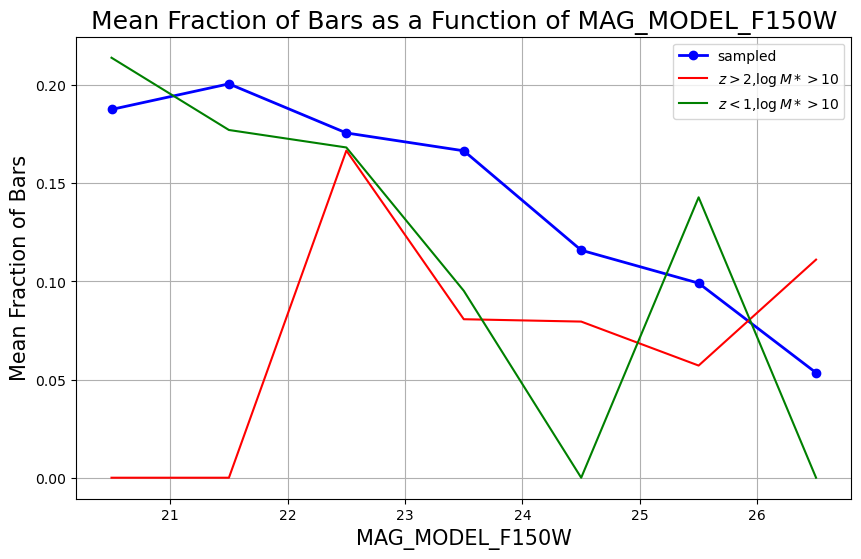

In [223]:
def calculate_fractions_and_plot(m150_disks, m150_bars, bins):
    # Histogram the data into these bins
    hist_disks, _ = np.histogram(m150_disks, bins=bins)
    hist_bars, _ = np.histogram(m150_bars, bins=bins)

    print(hist_disks)
    print(hist_bars)
    
    # Calculate the fraction of bars
    total = hist_disks + hist_bars
    #print(total[total>0])
    fraction_bars = np.divide(hist_bars, total)  # Avoid division by zero
    fraction_bars[total==0]=0
    print(fraction_bars)

    # Plot
    bin_centers = (bins[:-1] + bins[1:]) / 2
    return bin_centers,fraction_bars
    ax.plot(bin_centers, fraction_bars, marker='o', linestyle='-', linewidth=2, label=label,c=color)







# Bin centers for plotting

# Define bins for MAG_MODEL_F150W
#mag_bins = np.linspace(min(disks_hz.MAG_MODEL_F150W.values), max(disks_hz.MAG_MODEL_F150W.values), 10)
mag_bins = np.arange(20, 28, 1)
# Digitize the magnitudes to get bin indices
bin_indices = np.digitize(disks_hz.MAG_MODEL_F150W.values, bins=mag_bins)

# Calculate the mean of x_hz in each bin
mean_x_hz = []
bin_centers = []

for i in range(1, len(mag_bins)):
    bin_mask = bin_indices == i
    if np.any(bin_mask):
        mean_x_hz.append(np.mean(x_hz[bin_mask]))
        bin_centers.append((mag_bins[i-1] + mag_bins[i]) / 2)

# Plot low-z data
#calculate_fractions_and_plot(disks_lz.MAG_MODEL_F150W.values, bars_lz.MAG_MODEL_F150W.values, ax_main, '$z<1$, $\log M*>10$',color='blue')

# Plot high-z data
bins_c, fbar = calculate_fractions_and_plot(disks_hz.MAG_MODEL_F150W.values, bars_hz.MAG_MODEL_F150W.values,np.arange(20, 28, 1))
bins_c_lz, fbar_lz = calculate_fractions_and_plot(disks_lz.MAG_MODEL_F150W.values, bars_lz.MAG_MODEL_F150W.values,np.arange(20, 28, 1))

# Set labels and limits
# Plotting the mean fraction of bars as a function of magnitude
plt.figure(figsize=(10, 6))
plt.plot(bin_centers, mean_x_hz, marker='o', linestyle='-', color='blue', linewidth=2,label='sampled')
plt.plot(bins_c,fbar,color='red', label='$z>2$,$\log M*>10$')
plt.plot(bins_c_lz,fbar_lz,color='green', label='$z<1$,$\log M*>10$')
plt.xlabel('MAG_MODEL_F150W', fontsize=15)
plt.ylabel('Mean Fraction of Bars', fontsize=15)
plt.title('Mean Fraction of Bars as a Function of MAG_MODEL_F150W', fontsize=18)
plt.legend()
plt.grid(True)
plt.show()

In [232]:
print(np.mean(mean_x_hz))
print(np.mean(fbar))
print(np.mean(fbar_lz))

0.14271239295725033
0.07074449015442805
0.11392559751886015


In [122]:
# make a dataloader
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

theta = np.zeros((len(disks_lz),2))
theta[:,0]=disks_lz.MAG_MODEL_F150W.values
theta[:,1]=np.log10(disks_lz.RADIUS.values*3600)

#x = np.array(disks_lz.p_bar)
x=x.reshape((len(x),1))
scaler.fit(theta)
loader = NumpyLoader(x=np.array(scaler.transform(theta)), theta=np.array(x))

(array([ 28., 155., 422., 465., 284., 119.,  47.,  18.,   5.,   3.]),
 array([-2.55504876, -1.82030972, -1.08557068, -0.35083164,  0.3839074 ,
         1.11864644,  1.85338548,  2.58812452,  3.32286356,  4.0576026 ,
         4.79234164]),
 <BarContainer object of 10 artists>)

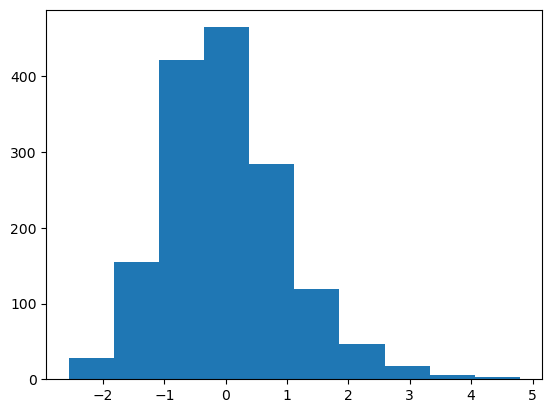

In [112]:
plt.hist(scaler.transform(theta)[:,1])

In [81]:
# create synthetic catalog
def simulator(params):
    # create toy simulations
    x = np.arange(10)
    y = 3 * params[0] * np.sin(x) + params[1] * x ** 2 - 2 * params[2] * x
    y += np.random.randn(len(x))
    return y

seed_sim = 12345
np.random.seed(seed_sim)
theta = np.random.rand(200, 3)  # 200 simulations, 3 parameters
x = np.array([simulator(t) for t in theta])

In [24]:
print(x.shape)

(200, 10)


In [123]:
# define a prior
prior = ili.utils.Uniform(low=[0], high=[1], device=device)

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_sbi(engine='NPE', model='maf', hidden_features=20, num_transforms=5),
    ili.utils.load_nde_sbi(engine='NPE', model='made', hidden_features=20, num_transforms=5),
    ili.utils.load_nde_sbi(engine='NPE', model='mdn', hidden_features=50, num_components=1)
]

# define training arguments
train_args = {
    'training_batch_size': 32,
    'learning_rate': 5e-7
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='sbi',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    embedding_net=None,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [124]:
# train the model
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 3.


 Training neural network. Epochs trained: 886

INFO:root:Training model 2 / 3.


 Training neural network. Epochs trained: 47 888 epochs.

INFO:root:Training model 3 / 3.


 Training neural network. Epochs trained: 27 48 epochs.

INFO:root:It took 92.96549201011658 seconds to train models.


 Neural network successfully converged after 30 epochs.

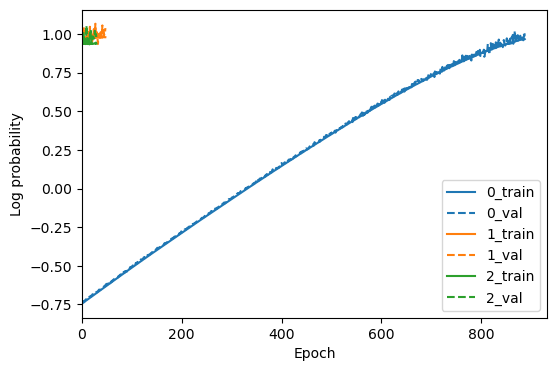

In [125]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [130]:
# Now, SBIRunner returns a custom class instance to be able to pass signature strings
# This class has simply for attributes a NeuralPosteriorEstimate and a string list 
print(posterior_ensemble.signatures)

# choose a random input
#seed_in = 49
#np.random.seed(seed_in)
ind = np.random.randint(len(x))

# generate samples from the posterior using accept/reject sampling
seed_samp = 32
torch.manual_seed(seed_samp)
samples = posterior_ensemble.sample((1000,), torch.Tensor(theta[ind]).to(device))

# calculate the log_prob for each sample
log_prob = posterior_ensemble.log_prob(samples, torch.Tensor(theta[ind]).to(device))

samples = samples.cpu().numpy()
log_prob = log_prob.cpu().numpy()

['', '', '']


Drawing 332 posterior samples:   0%|          | 0/332 [00:00<?, ?it/s]

Drawing 335 posterior samples:   0%|          | 0/335 [00:00<?, ?it/s]

Drawing 333 posterior samples:   0%|          | 0/333 [00:00<?, ?it/s]

834


Text(0, 0.5, '$N_{samples}$')

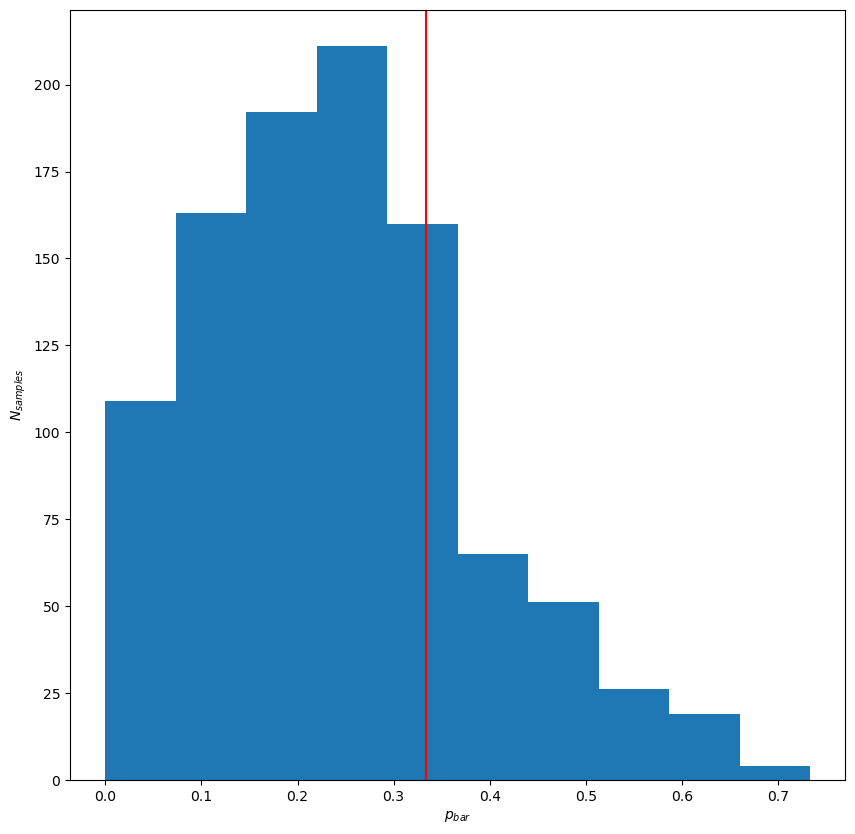

In [131]:
# plot the posterior samples and the true value
fig, axs = plt.subplots(1, 1, figsize=(10,10))

print(ind)
axs.hist(samples[:,0], label='samples')
axs.axvline(x[ind,0], color='red', markersize=10, label='true')
    
#axs.set_aspect('equal')
#axs[i].set_xlim(0,1)
#axs[i].set_ylim(0,1)
axs.set_xlabel('$p_{bar}$')
axs.set_ylabel('$N_{samples}$')


100%|██████████| 100/100 [00:00<00:00, 122.72it/s]


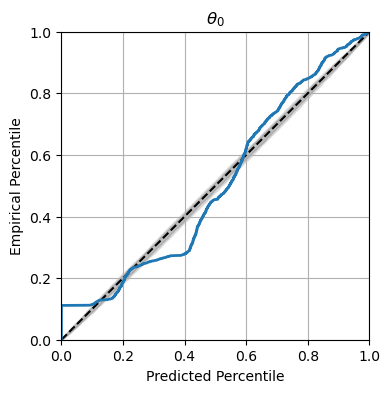

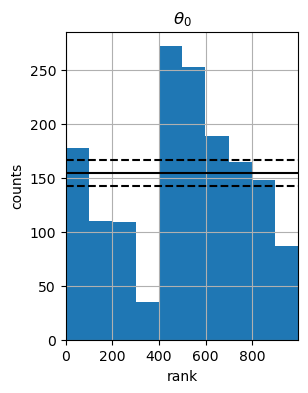

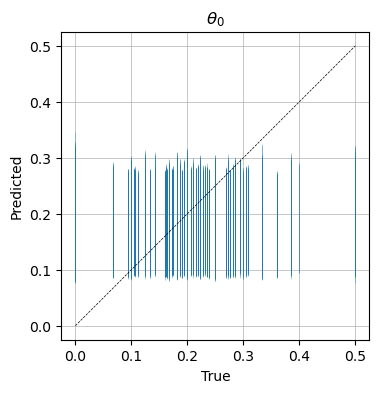

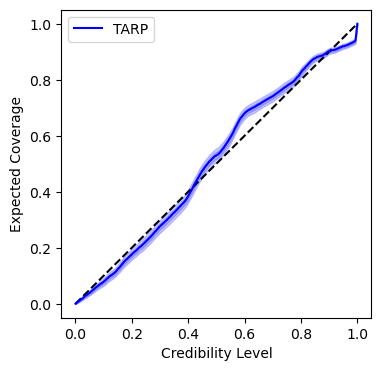

In [132]:
# Drawing samples from the ensemble posterior

metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct', 
    labels=[f'$\\theta_{i}$' for i in range(3)],
    plot_list = ["coverage", "histogram", "predictions", "tarp"],
    out_dir=None
)

fig = metric(
    posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x=scaler.transform(theta), theta=x
)

100%|██████████| 100/100 [00:00<00:00, 121.23it/s]


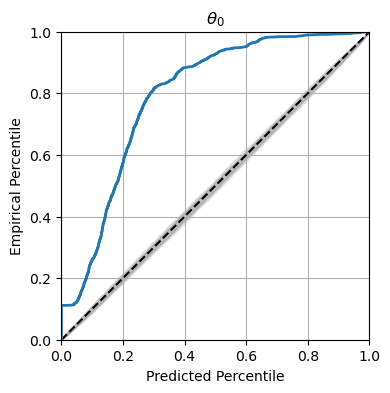

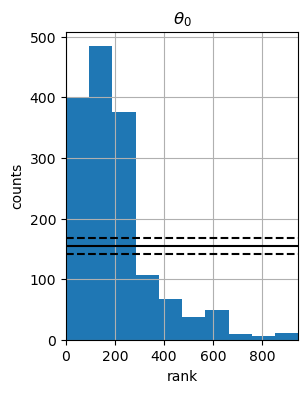

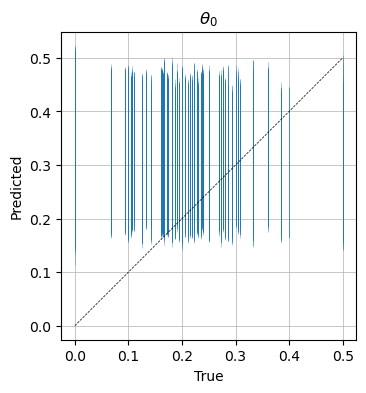

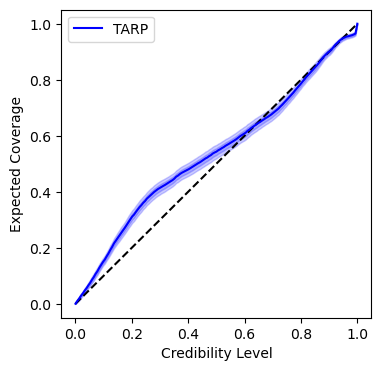

In [136]:
# Drawing samples for each posterior in the ensemble
# First the MAF posterior
metric = PosteriorCoverage(num_samples=1000, 
    sample_method='direct', labels=[f'$\\theta_{i}$' for i in range(3)],
    plot_list = ["coverage", "histogram", "predictions", "tarp"])

fig = metric(
    posterior=posterior_ensemble.posteriors[1],
    x=theta, theta=x
)

(array([173.,  76., 174., 354., 469., 188.,  71.,  24.,   3.,  14.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ]),
 <BarContainer object of 10 artists>)

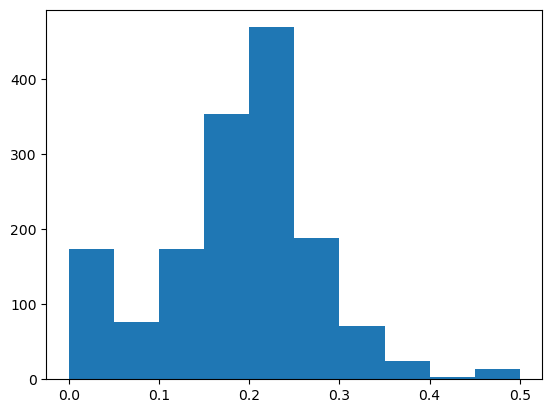

In [137]:
plt.hist(x)